# ECAPA-TDNNでの話者照合


Hugging Faceで公開されているECAPA-TDNNを用いて、話者照合を行いましょう。


環境構築が簡単なので、Google Colab上で実行することをお勧めします。


もし手元のPCで動かしたい、Google Colabの使い方が分からないなど要望があれば、いつでも相談してください！


 * Hugging Faceの公式ページ -> https://huggingface.co/

* 今回用いるECAPA-TDNNのページ ->https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb

In [1]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS_seminar/6th

/content/drive/MyDrive/CS_seminar/6th


In [ ]:
%cd /content

/content


In [ ]:
#pythonのバージョン確認
!python -V

Python 3.10.12


In [ ]:
#cudaのバージョン確認
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
#必要なライブラリのインストール
!pip install speechbrain
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib japanize-matplotlib typing scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 14.7 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 46.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=304eb8d379d107a596918a60b10f16eb5def05894e378519062f8d4da59557aa
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=b

In [ ]:
#事前学習モデルのロード
from speechbrain.pretrained import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir="pretrained_models/spkrec-ecapa-voxceleb",
    run_opts={"device":"cuda"},
    )

hyperparams.yaml:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

In [ ]:
from typing import List
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import roc_curve ,auc
import matplotlib.pyplot as plt

from tqdm import tqdm
import re

In [ ]:
#EERを求める関数
#FRR=1-TPRであることに留意
def compute_eer(labels: List[int], scores: List[float]):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
    eer_threshold = interp1d(fpr, thresholds)(eer)
    return fpr, tpr, thresholds, eer, eer_threshold

複数のwav_pair_listに対してEERとROCカーブを出力する処理を行いたいため，処理を関数化．

In [ ]:
# ディレクトリ移動
%cd /content/

# /content/drive/ 内からdrive/内にファイルを作成しようとしたらエラーが出るので，目的のディレクトリを保持しておく．
TAR_DIR = "/content/drive/MyDrive/CS_seminar/6th"
LIST_DIR = "/content/drive/MyDrive/CS_seminar/data/list"

/content


In [ ]:
def parse_listfile(wav_list_path):
  labels = []
  wav1 = []
  wav2 = []

  with open(wav_list_path) as f:
    for line in f:
      line = line.rstrip().split(' ')
      labels.append(int(line[0]))
      wav1.append(line[1])
      wav2.append(line[2])
  return labels, wav1, wav2

In [ ]:
def gen_audio_cache_filename(wav_path):
  result = re.match(r".*/(.+?)/([_mn]+)/(.+?)\.wav", wav_path)
  spk, cond, wavname = result.groups()
  return f"{spk}-{cond}-{wavname}"

#### `SpeakerRecognition.verify_files(self, path_x, path_y, **kwargs)`について
- 中で呼び出されている`self.load_audio(path_x/y, **kwargs)`で，音声を`./audio_cache`にキャッシュしている．
- この時，`**kwargs==None`だと，参照する音声ファイルの`{filename}.wav`を`./audio_cache`にキャッシュする．
- また，同じ`**kwargs`を二つの音声に対する`load_audio()`に渡している．
- これでは同一のファイル名の音声が同一のファイルとして参照されてしまい，違う話者and同一のwav名の場合に正しくスコアが計算できない．
- したがって，キャッシュする音声のファイル名にディレクトリの情報を保持できるように処理を変更する．

---

`SpeakerRecognition.verify_files(*)`は`/usr/local/lib/python3.10/dist-packages/speechbrain/pretrained/interfaces.py`@1198に実装されています．

`Pretrained.load_audio(*)`は@274で実装されています．`**kwargs`に与えられるキーワードは`/usr/local/lib/python3.10/dist-packages/speechbrain/pretrained/fetching.py`に説明されています．




In [ ]:
def calc_scores(labels, wav1, wav2):
  scores = []
  for i in tqdm(range(len(labels))):
###
    waveform_x = verification.load_audio(
        wav1[i],
        save_filename=gen_audio_cache_filename(wav1[i])
        )
    waveform_y = verification.load_audio(
        wav2[i],
        save_filename=gen_audio_cache_filename(wav2[i])
        )
    # Fake batches:
    batch_x = waveform_x.unsqueeze(0)
    batch_y = waveform_y.unsqueeze(0)
    # Verify:
    score, decision = verification.verify_batch(batch_x, batch_y)
    # Squeeze:
    score, prediction = score[0], decision[0]
###
    scores.append(score.item())
  return scores


In [ ]:
def eer_roc_pipeline(wav_list_path):
  # 音声対が列挙されたファイルを，ラベル，音声1，音声2のリストに分割
  labels, wav1, wav2 = parse_listfile(wav_list_path)
  # 音声ファイル対について，スコアを計測
  scores = calc_scores(labels, wav1, wav2)
  # 評価値を計算
  fpr, tpr, th, eer, eer_th = compute_eer(labels, scores)

  #FAR,FRR,EERの図のプロット
  title = re.match(r".*/([_mn]+).txt", wav_list_path).group(1)
  plt.figure()
  plt.plot(th, fpr, marker='o', markersize=1, label="FAR")
  plt.plot(th, 1-tpr, marker='o', markersize=1, label="FRR")
  plt.plot(eer_th,eer,marker='*', markersize=10, color="red")
  plt.xlabel('Threshold')
  plt.ylabel('Error Rate')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
  plt.title(f"Error Rate Curve: {title}, EER: {eer:.5f}")
  plt.grid()
  plt.savefig(f"{TAR_DIR}/fig/{title}.png", bbox_inches='tight', dpi=600)

  # スコアを外部に記録
  SCORE_LOG[f"{title}"] = scores

  # 詳細を出力
  print(f"wav_list:{wav_list_path}")
  print(f"pairs:{len(labels)}")
  # print("fpr:", fpr)
  # print("tpr:", tpr)
  # print("roc_th:", th)
  print("eer:", eer)
  print("eer_th:", eer_th)


  # キャッシュを削除
  !rm -r /content/audio_cache/


In [ ]:
SCORE_LOG = {}

100%|██████████| 820/820 [00:39<00:00, 20.58it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/__.txt
pairs:820
eer: 0.17187500000000003
eer_th: 0.22031925876386635


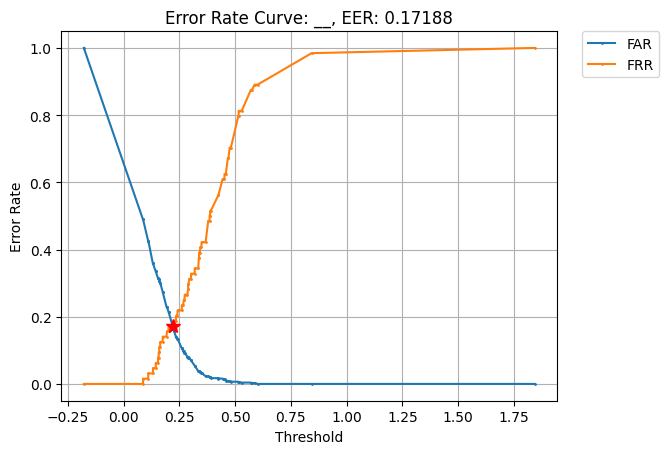

In [ ]:
# `__`
eer_roc_pipeline(f"{LIST_DIR}/__.txt")

100%|██████████| 820/820 [00:38<00:00, 21.33it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/_n.txt
pairs:820
eer: 0.24735449735364057
eer_th: 0.1595095098021544


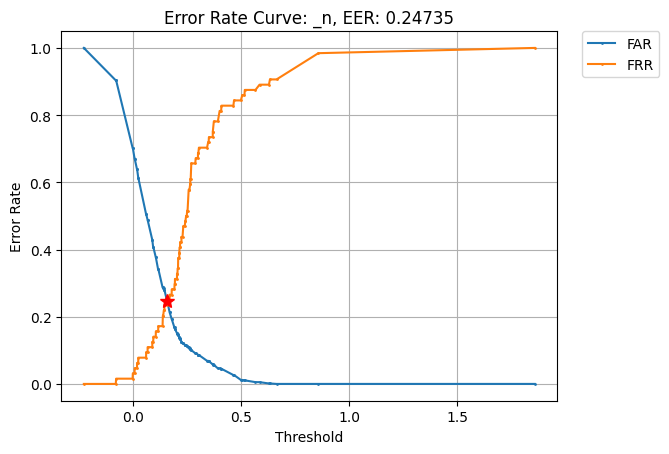

In [ ]:
# `_n`
eer_roc_pipeline(f"{LIST_DIR}/_n.txt")

100%|██████████| 231/231 [00:11<00:00, 20.62it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/m_.txt
pairs:231
eer: 0.2631578947368422
eer_th: 0.1779251396656036


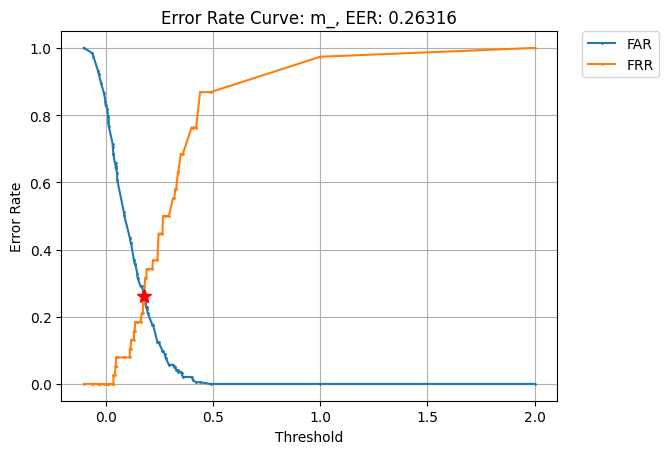

In [ ]:
# `m_`
eer_roc_pipeline(f"{LIST_DIR}/m_.txt")

100%|██████████| 231/231 [00:11<00:00, 20.67it/s]


wav_list:/content/drive/MyDrive/CS_seminar/data/list/mn.txt
pairs:231
eer: 0.39378238341903565
eer_th: 0.14726151525990736


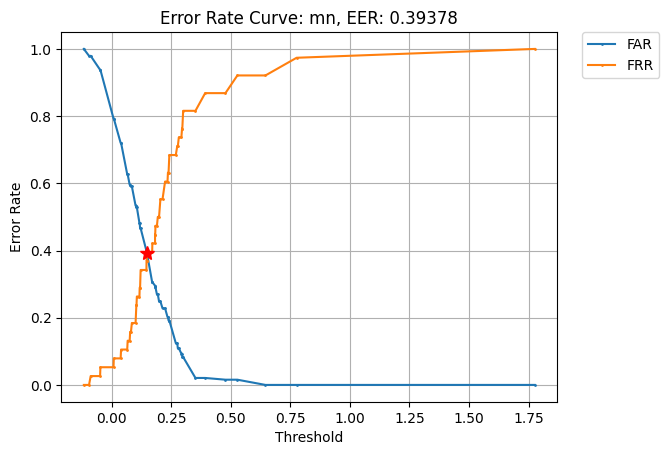

In [ ]:
# `mn`
eer_roc_pipeline(f"{LIST_DIR}/mn.txt")

---
類似度の分布も見てみる
条件ごとのscore(cos_simil)の分布

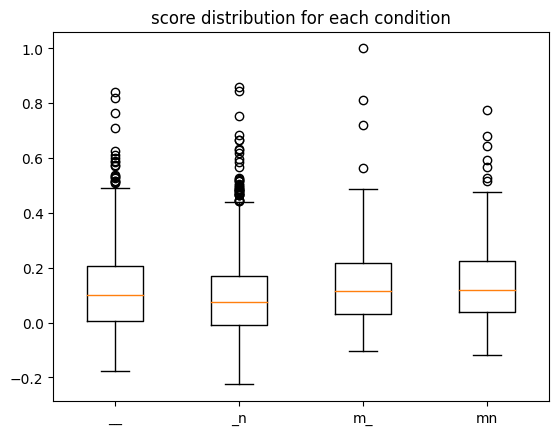

In [ ]:
plt.figure()
plt.boxplot(SCORE_LOG.values(), labels=SCORE_LOG.keys())
plt.title("score distribution for each condition")
plt.savefig(f"{TAR_DIR}/fig/score_box.png", bbox_inches='tight', dpi=600)